In [1]:
from __future__ import print_function
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
from time import time

# subset = "val"
# file_root = "/data/coco/coco-2017/coco2017/" + subset + "2017"
# annotations_file = "/data/coco/coco-2017/coco2017/annotations/instances_" + subset + "2017.json"
annotations_file = "/home/lishuang/Disk/github/oasp_centernet/voc/annotations/pascal_trainval0712.json"
file_root = "/home/lishuang/Disk/github/oasp_centernet/voc/images"
num_gpus = 1
batch_size = 16

In [2]:
class COCOPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(COCOPipeline, self).__init__(
            batch_size, num_threads, device_id, seed=15)
        self.input = ops.COCOReader(
            file_root=file_root,
            annotations_file=annotations_file,
            shard_id=device_id,
            num_shards=num_gpus,
            ratio=True,
            ltrb=True)
        
        
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)

        self.resize = ops.Resize(device="gpu", image_type=types.RGB, resize_x=576,
                                 resize_y=416, interp_type=types.DALIInterpType.INTERP_TRIANGULAR)

        self.twist = ops.ColorTwist(device="gpu",image_type=types.RGB)
        self.rng1 = ops.Uniform(range=[0.5, 1.5])
        self.rng2 = ops.Uniform(range=[0.875, 1.125])
        self.rng3 = ops.Uniform(range=[-0.5, 0.5])

        self.flip = ops.Flip(device="gpu")
        self.bbflip = ops.BbFlip(device="cpu", ltrb=True)
        self.flip_coin = ops.CoinFlip(probability=0.5)
        self.flip_coin2 = ops.CoinFlip(probability=0.5)

#         self.paste_pos = ops.Uniform(range=(0, 1))
#         self.paste_ratio = ops.Uniform(range=(1, 2))
        self.paste_pos = ops.Uniform(range=(0, 1))
        self.paste_ratio = ops.Uniform(range=(1, 1.25))
        self.paste = ops.Paste(device="gpu", fill_value=(0, 0, 0))
        self.bbpaste = ops.BBoxPaste(device="cpu", ltrb=True)
        self.prospective_crop = ops.RandomBBoxCrop(device="cpu",
                                                   aspect_ratio=[1.0, 1.0],
                                                   thresholds=[0.1,0.3,0.5],
                                                   scaling=[0.3, 1.0],
                                                   ltrb=True)
        
        self.slice = ops.Slice(device="gpu")

        output_fp16=False
        output_nhwc=False
        output_dtype = types.FLOAT16 if output_fp16 else types.FLOAT
        output_layout = types.NHWC if output_nhwc else types.NCHW
        mean=[0.485, 0.456, 0.406]
        mean=[x * 255.0 for x in mean]
        std=[0.229, 0.224, 0.225]
        std = [x * 255.0 for x in std]
        self.normalize = ops.CropMirrorNormalize(device="gpu",
                                             mean=mean,
                                             std=std,
                                             mirror=0,
                                             image_type=types.RGB,
                                             output_dtype=output_dtype,
                                             output_layout=output_layout,
                                             pad_output=False)

    def define_graph(self):
        saturation = self.rng1()
        contrast = self.rng1()
        brightness = self.rng2()
        hue = self.rng3()
        coin_rnd = self.flip_coin()
        coin_rnd2 = self.flip_coin2()
        inputs, bboxes, labels = self.input(name="Reader")
        images = self.decode(inputs)

        ratio = self.paste_ratio()
        px = self.paste_pos()
        py = self.paste_pos()
        
        images = self.paste(images, paste_x=px, paste_y=py, ratio=ratio)
        bboxes = self.bbpaste(bboxes, paste_x=px, paste_y=py, ratio=ratio)
        
        crop_begin, crop_size, bboxes, labels = self.prospective_crop(bboxes, labels)
        images = self.slice(images, crop_begin, crop_size)
        
        


#         images = self.flip(images, horizontal=coin_rnd, vertical=coin_rnd2)
#         bboxes = self.bbflip(bboxes, horizontal=coin_rnd, vertical=coin_rnd2)

        images = self.resize(images)

#         images = self.twist(images.gpu(), saturation=saturation, contrast=contrast, brightness=brightness, hue=hue)

        #images = self.normalize(images)

        # bboxes and images and labels on GPU
        return (images, bboxes.cpu(), labels.cpu())

In [3]:

start = time()
pipes = [COCOPipeline(batch_size=batch_size, num_threads=2, device_id=device_id)  for device_id in range(num_gpus)]
for pipe in pipes:
    pipe.build()
total_time = time() - start
print("Computation graph built and dataset loaded in %f seconds." % total_time)

Computation graph built and dataset loaded in 0.687166 seconds.


In [4]:
pipe_out = [pipe.run() for pipe in pipes]

images_cpu = pipe_out[0][0].as_cpu()
bboxes_cpu = pipe_out[0][1]
labels_cpu = pipe_out[0][2]

In [5]:

img_index = 1

bboxes = bboxes_cpu.at(4)
bboxes

array([[0.05443525, 0.31522492, 0.35000756, 0.63507134]], dtype=float32)

416 576


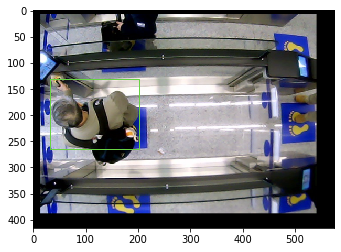

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
img_index=4
img = images_cpu.at(img_index)

H = img.shape[0]
W = img.shape[1]
print(H,W)
fig,ax = plt.subplots(1)

ax.imshow(img)
bboxes = bboxes_cpu.at(img_index)
labels = labels_cpu.at(img_index)
categories_set = set()
for label in labels:
    categories_set.add(label[0])

category_id_to_color = dict(
    [(cat_id, [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]) for cat_id in categories_set])

for bbox, label in zip(bboxes, labels):
    rect = patches.Rectangle(
        (bbox[0] * W, bbox[1] * H), # Absolute corner coordinates
        (bbox[2] - bbox[0]) * W,    # Absolute bounding box width
        (bbox[3] - bbox[1]) * H,    # Absolute bounding box height
        linewidth=1,
        edgecolor=category_id_to_color[label[0]],
        facecolor='none')
    ax.add_patch(rect)

plt.show()

'0.13.0'